In [1]:
import numpy as np
import matplotlib as plt
import pandas as pd
import yfinance as yf
import importlib
import dataReading 
import sympy as sp 


In [2]:
# How to load all functions from a file into the notebook
importlib.reload(dataReading) # Needed so that you dont need to reload kernel when changing function
from dataReading import *

## Lab 1 Enterprise Risk Management

## 1. Daily volatility forecast using MA and EWMA

Perform a daily volatility forecast using MA and EWMA with a 60 day estimation window, over the time period
2020-01-01 -> 2023-12-31 for the Nasdaq 100 index (^NDX). Plot the daily forecasts in the same plot. 
Plot also the log-returns in a separate plot below.

*Discussion: What is the main reason for the differences in these two forecasts.*

The moving average forecast puts equal weight on all observations in the estimation period. In our case this means that the square returns observed 60 days ago has the same weight as the one seen yesterday. This is in contrast to the exponentially weighted moving average forecast which puts less and less weights on observations the longer ago they were observed. This makes it so that the EWMA better captures the autocorrelation of the square returns and hence becomes more reactive to recent events. 

In [19]:
### To download data and store it as a csv file in the folder DataFileFolder. The filename is price_<TICKER>
# ticker = '^NDX'
# startDate = '2020-01-01'
# endDate = '2023-12-31'
# stockData = readDataFromYahoo(ticker, startDate, endDate)

# fileName = saveDataToCsv(stockData = stockData, stockName = ticker)

In [93]:
# To download data from file
stockDataFromFile = readDataFromFile('price_^NDX.csv')
price = stockDataFromFile[['Close']]

price['logReturns'] = np.log(price).diff()
price['squarePrice'] = price['logReturns'] ** 2
#logReturns = np.log(price).diff().dropna()
#logReturns['squarePrice'] = logReturns['Close'] ** 2
price = price.dropna() 
price.head()


C:\Users\Bolli\AppData\Local\Temp\ipykernel_11116\4168434398.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['logReturns'] = np.log(price).diff()
C:\Users\Bolli\AppData\Local\Temp\ipykernel_11116\4168434398.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['squarePrice'] = price['logReturns'] ** 2


,Close,logReturns,squarePrice
Date,,,
2020-01-03 00:00:00-05:00,8793.900391,-0.008867,7.861788e-05
2020-01-06 00:00:00-05:00,8848.519531,0.006192,3.833859e-05
2020-01-07 00:00:00-05:00,8846.450195,-0.000234,5.470441e-08
2020-01-08 00:00:00-05:00,8912.370117,0.007424,5.511491e-05
2020-01-09 00:00:00-05:00,8989.629883,0.008631,7.450219e-05


In [94]:
T = 60
volatilityEstimateMA = np.zeros(price.shape[0]-T)

for i in range(len(volatilityEstimateMA)):
    volatilityEstimateMA[i] = np.sqrt( np.mean( price.iloc[i:(i+T)]['squarePrice']))



In [95]:
volatilityEstimateEWMA = np.zeros(price.shape[0]-T)
initialVolatility = np.sqrt(np.mean( price.iloc[0:T]['squarePrice']))
lambdaValue = 0.94

for i in range(len(volatilityEstimateEWMA)):
    volatilityEstimateEWMA[i] = np.sqrt( (1-lambdaValue) *  price.iloc[(i+T)]['squarePrice'] + lambdaValue* initialVolatility ** 2)
    initialVolatility = volatilityEstimateEWMA[i]


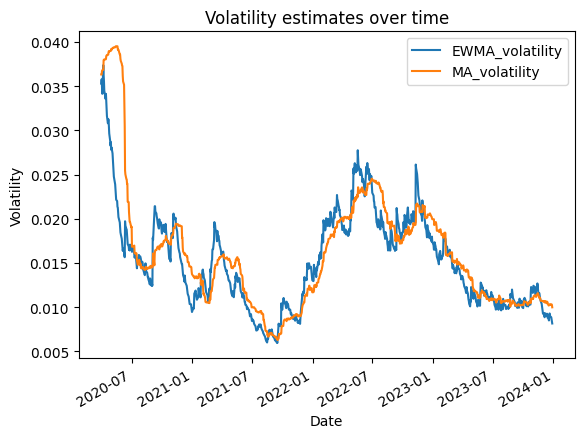

In [96]:
volatilityDf = price.iloc[T:][['Close', 'logReturns']]
volatilityDf['MA_volatility'] = volatilityEstimateMA
volatilityDf['EWMA_volatility'] = volatilityEstimateEWMA

volatilityDf[['EWMA_volatility','MA_volatility']].plot(title = 'Volatility estimates over time', ylabel='Volatility' );

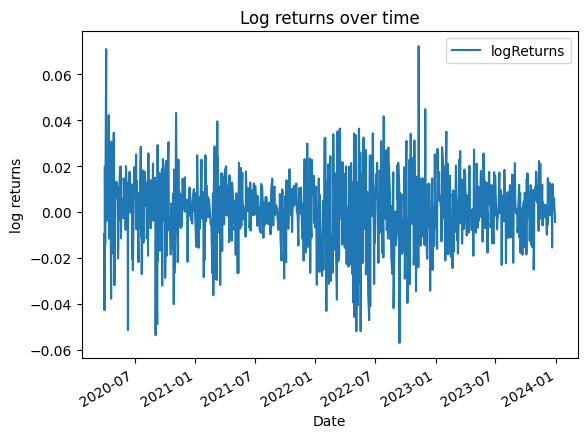

In [97]:
volatilityDf[['logReturns']].plot(title = 'Log returns over time', ylabel = 'log returns');

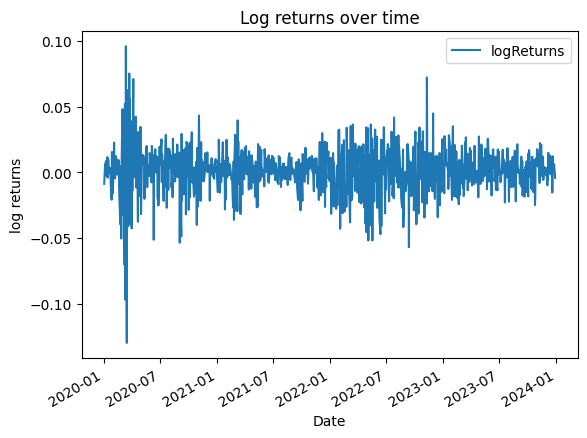

In [98]:
price[['logReturns']].plot(title = 'Log returns over time', ylabel = 'log returns');

## 2. Daily volatility forecast using GARCH

Fit a GARCH(1,1)-model using Nasdaq return data for the time period 2010-01-01 -> 2019-12-31 and then
perform a daily volatility forecast as in 1, with forecasting period: 2020-01-01 -> 2023-12-31. Plot your daily
forecast in the same plot as in 1.

*Discussion: What is the main reason for the difference between the GARCH and the EWMA forecast.*

The main difference between GARCH and EWMA is that GARCH gives the volatility estimate a floor so that it can not go under the long term volatility level. 

In [78]:
### To download data and store it as a csv file in the folder DataFileFolder. The filename is price_<TICKER>
# ticker = '^NDX'
# startDate = '2010-01-01'
# endDate = '2023-12-31'
# stockData = readDataFromYahoo(ticker, startDate, endDate)

# fileName = saveDataToCsv(stockData = stockData, stockName = ticker)

In [99]:
# To download data from file
stockDataFromFile = readDataFromFile('price_^NDX_2024-09-10.csv')
price = stockDataFromFile[['Close']]

price['logReturns'] = np.log(price).diff()
price['squarePrice'] = price[['logReturns']] ** 2
price['multipliedSqPrice'] = (100 * price[['logReturns']]) ** 2
#logReturns = np.log(price).diff().dropna()
#logReturns['squarePrice'] = logReturns['Close'] ** 2
price = price.dropna() 
price.head()

splitDate = pd.Timestamp('2020-01-01', tz='UTC')

# Spliting DataFrame into estimation and testing period 
estimationPeriod = price[price.index < splitDate]
testPeriod = price[price.index >= splitDate]

C:\Users\Bolli\AppData\Local\Temp\ipykernel_11116\1719077471.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['logReturns'] = np.log(price).diff()
C:\Users\Bolli\AppData\Local\Temp\ipykernel_11116\1719077471.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['squarePrice'] = price[['logReturns']] ** 2
C:\Users\Bolli\AppData\Local\Temp\ipykernel_11116\1719077471.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [154]:
## Parameter estimation
def likelihoodFunction(dataFrame, omega, alpha, beta):
    initialVolatility = np.std(dataFrame['multipliedSqPrice']) # Not the same variance as in task 1 ???

    volatilityVector = np.zeros(len(dataFrame))
    volatilityVector[0] = initialVolatility
    terms = np.zeros(len(dataFrame)-1)

    for i in range(1, len(dataFrame)):
        volatilityVector[i] = np.sqrt(omega + alpha * float(dataFrame.iloc[i-1]['multipliedSqPrice'])  + beta * volatilityVector[i-1] ** 2)
        terms[i-1] = np.log(volatilityVector[i] ** 2) + float(dataFrame.iloc[i]['multipliedSqPrice']) / (volatilityVector[i] ** 2)
        
    likelihood = -1/2 * (sum(terms))
    return likelihood


omega = np.linspace(0.05, 0.06,10)
alpha = np.linspace(0.1, 0.15,10)
beta = np.linspace(0.8, 0.85, 10)

OMEGA, ALPHA, BETA = np.meshgrid(omega, alpha, beta)


likelihood = np.zeros(OMEGA.shape)

for i in range(OMEGA.shape[0]):
    for j in range(OMEGA.shape[1]):
        for k in range(OMEGA.shape[2]):
            if (ALPHA[i,j,k] + BETA[i,j,k] >= 1):
                break

            likelihood[i,j,k] = likelihoodFunction(estimationPeriod, OMEGA[i,j,k], ALPHA[i,j,k], BETA[i,j,k])


In [155]:
## Find best point

np.max(likelihood)
maxValue = np.max(likelihood[likelihood != 0])
maxIndex = np.unravel_index(np.argmax(likelihood == maxValue), likelihood. shape)

print('Index for max value and max value')
print(maxIndex, maxValue)

valuesOfParameters = (OMEGA[maxIndex]/100**2, ALPHA[maxIndex], BETA[maxIndex])
print('Values of (omega, alpha, beta)')
print(valuesOfParameters)

print(valuesOfParameters[0]*100**2)

Index for max value and max value
(4, 2, 6) -1230.5285176373088
Values of (omega, alpha, beta)
(5.2222222222222226e-06, 0.12222222222222222, 0.8333333333333334)
0.052222222222222225


In [156]:
## Volatility estimation
omega = valuesOfParameters[0]
alpha = valuesOfParameters[1]
beta =  valuesOfParameters[2]

volatilityEstimateGARCH = np.zeros(testPeriod.shape[0])
initialVolatility = np.sqrt(np.mean( estimationPeriod['squarePrice']))
volatilityEstimateGARCH[0] = initialVolatility 

for i in range(0, len(volatilityEstimateGARCH)):
    volatilityEstimateGARCH[i] = np.sqrt(omega + alpha *  price.iloc[i]['squarePrice'] +  beta * (initialVolatility ** 2))
    initialVolatility = volatilityEstimateGARCH[i]

In [159]:
# volatilityDfGRACH = testPeriod[['Close', 'logReturns']].copy()
# volatilityDfGRACH.loc[:, 'GARCH_volatility'] = volatilityEstimateGARCH
# volatilityDfGRACH['GARCH_volatility'].plot(title = 'Volatility estimates over time', ylabel='Volatility' );

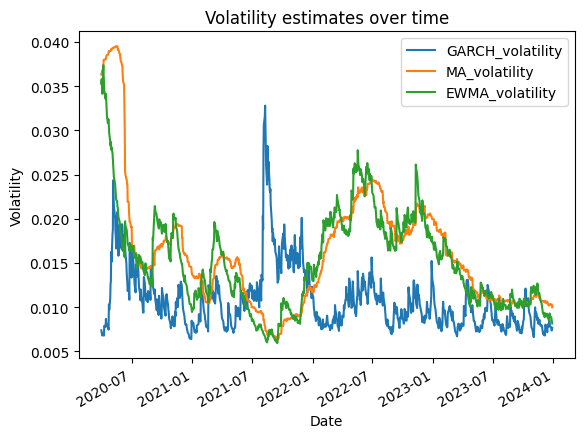

In [160]:
volDF = volatilityDf[['Close', 'logReturns', 'MA_volatility', 'EWMA_volatility']].copy()
volDF['GARCH_volatility'] = volatilityEstimateGARCH[T+1:]
volDF[['GARCH_volatility', 'MA_volatility', 'EWMA_volatility']].plot(title = 'Volatility estimates over time', ylabel='Volatility');

## 3. GARCH model diagnostics

Analyze the GARCH-model and perform model diagnostics:
- a) What are the GARCH-parameters and what is the unconditional volatility?
- b) Plot the ACF (for lags 1 to 200) for the returns and the squared returns (use a stem-plot).
- c) Plot the ACF (for lags 1 to 200) for the residuals and the squared residuals (use a stem-plot).
- d) Plot a histogram (using 100 bins) of the residuals together with a normal pdf (same mean and std).
- e) QQ-plot the residuals against normal- and student t quantiles. What t-distribution provides the best fit
to the left tail?

*Discussion: What does b) and c) tell you? What does d), e) and f) tell you?*

## 4. VaR forecasts using historical simulation

Use backtesting to compare daily VaR98%-forecasts for the period 2020-01-01 -> 2023-12-31 using two versions
of basic historical simulation with rolling estimation windows of length 500 and 1000 days respectively.
- a) Plot the VaR-forecasts in the same plot as the (negative) returns
- b) Calculate the violation ratios for the different methods and give the number of violations for each
method in the report

*Discussion: What are the pros and cons of using these methods?*

## 5. VaR forecasts using GARCH and FHS

Repeat the backtest procedure in 4 but now based on the GARCH-model from 2. The two models to backtest
are:
- GARCH with the assumption of normally distributed conditional returns
- One-period filtered historical simulation (FHS)

You do not need to recalibrate the GARCH-model during the backtest period.
- a) Plot the VaR-forecasts in the same plot as in 4
- b) Calculate the violation ratios

*Discussion: What are the pros and cons of using these methods?*